In [153]:
%matplotlib notebook

# import modules
import random
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from matplotlib import cm
from pathlib import Path
import os
cwd = os.getcwd()
#import statsmodels.stats.moment_helpers
#from datetime import datetime
#import multiprocessing as mp
import csv
import networkx as nx
from IPython.display import HTML
from matplotlib import animation
import networkx as nx

# Setup

## Parameters

In [154]:
plotIter = 360*2*10
nnodes = 250
p_link = .1
leak = .2 #
leaktype = 1 #1 = leak a percentage, or 2 = leak a constant rate
lrate_wmat = .01
lrate_targ = .01
targ_min = 1 
sens_offset = 30
rot_amp = 20
input_amp = .75
forward_amp = .2
spike_cost = 0#.1
stim_speed = 1
noise_sd = 0#.2
weight_sd_init = 1#5
effector_type = 1 # 1 = separate output nodes (totally untrained / non-allostatic), 2 = select random nodes in reservoir as output nodes (nodes are trained)
acts_neg=0

## Set up sensor nodes and input connections

In [155]:
sens_degrees = np.concatenate([np.flip(np.arange(-61,63,4)+30), np.flip(np.arange(-60,64,4)-30)])

input_wmat=np.zeros((len(sens_degrees),nnodes))
for row in range(input_wmat.shape[0]):
    for col in range(nnodes):
        input_wmat[row,col]=random.choices([0,input_amp], weights=(1-p_link,p_link), k=1)[0]


## Set up internal weight matrix

In [156]:
link_mat = np.zeros((nnodes,nnodes))
inhibitory_nodes=[]
for row in range(link_mat.shape[0]):
    inhibitory = random.choices([0,1],weights=(.75,.25),k=1)[0]
    if inhibitory == 1:
        inhibitory_nodes.append(row)
    for col in range(link_mat.shape[1]):
        if row == col:
            continue
        if inhibitory == 1:
            link_mat[row,col] = random.choices([0,-1], weights=(1-p_link,p_link), k=1)[0]
        else:
            link_mat[row,col] = random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]
        
wmat=np.zeros((nnodes,nnodes))
for row in range(wmat.shape[0]):
    for col in range(wmat.shape[1]):
        if link_mat[row,col] == 1:
            wmat[row,col] =  np.random.normal(input_amp,.1)
        if link_mat[row,col] == -1:
            wmat[row,col] = np.random.normal(-input_amp,.1)
            
start_wmat=wmat.copy()

In [157]:
effector_nodes=[]
output_wmat=np.zeros((nnodes,3))
for row in range(output_wmat.shape[0]):
    for col in range(output_wmat.shape[1]):
        output_wmat[row,col]=random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]
        if output_wmat[row,col] != 0:
            effector_nodes.append(row)

## Functions

In [158]:
def get_plot_vals(degree, heading,position):
    x = 10*np.cos(np.radians(degree))
    y = 10*np.sin(np.radians(degree))
    
    sLdeg = heading + sens_offset
    if sLdeg >= 360:
        sLdeg = sLdeg - 360
    sRdeg = heading - sens_offset
    if sRdeg < 0:
        sRdeg = 360 + sRdeg
        
    sLx = .5*np.cos(np.radians(sLdeg)) + position[0]
    sLy = .5*np.sin(np.radians(sLdeg)) + position[1]
    sLpos = np.array([sLx,sLy])
    
    sRx = .5*np.cos(np.radians(sRdeg)) + position[0]
    sRy = .5*np.sin(np.radians(sRdeg)) + position[1]
    sRpos = np.array([sRx, sRy])
    
    return x, y, sLx, sLy, sRx, sRy

def move_stim(degree, direction):
    if direction == 1:
        degree += stim_speed
    else:
        degree -= stim_speed
        
    if degree > 360:
        degree = degree - 360
    if degree < 0:
        degree = degree + 360

    return degree

def move_agent(output_acts, heading, position):
    
    diff = (output_acts[0] - output_acts[1])*rot_amp #rotates clockwise when left sensor is more active
    heading = heading + diff
    
    if heading > 360:
        heading = heading - 360
    if heading < 0:
        heading = heading + 360
        
    #r = output_acts[2]*forward_amp
    r = (output_acts[2])*forward_amp
    dx = r * np.cos(np.radians(heading))
    dy = r * np.sin(np.radians(heading))
    position[0]+= dx
    position[1]+= dy

    # for euc dist
    if position[0] > 5:
        position[0] = 5
        
    if position[0] < -5:
        position[0] = -5
        
    if position[1] > 5:
        position[1] = 5
        
    if position[1] < -5:
        position[1] = -5
    
    return heading, position

def euc_dist(point1, point2):
    xdiff = abs(point1[0] - point2[0])
    ydiff = abs(point1[1] - point2[1])
    euc_dist = np.sqrt(xdiff**2 + ydiff**2)
    
    return euc_dist

def angle_between(position, heading, stim_pos):
    x = stim_pos[0]-position[0]
    y = stim_pos[1]-position[1]
    
    angle = np.arctan2(y, x) * 180 / np.pi
    #angle = np.degrees(np.arctan2(y, x))
    if angle < 0:
        angle = 360+angle
    
    angDist = angle - heading
    
    ang_dL = np.abs(angDist - sens_offset)
    if ang_dL > 180:
        ang_dL = 360 - ang_dL
    ang_dR = np.abs(angDist + sens_offset)
    if ang_dR > 180:
        ang_dR = 360 - ang_dR
    
    return angDist, ang_dL, ang_dR


def get_input_acts(heading, position, degree):
       
    stim_pos = [10*np.cos(np.radians(degree)),10*np.sin(np.radians(degree))]
    
    sLheading = heading + sens_offset
    if sLheading >= 360:
        sLheading = sLheading - 360
        
    sRheading = heading - sens_offset
    if sRheading < 0:
        sRheading = sRheading + 360
        
    sRx = .5*np.cos(np.radians(sRheading))+position[0]
    sRy = .5*np.sin(np.radians(sRheading))+position[1]
    sRpos = np.array([sRx, sRy])
    
    sLx = .5*np.cos(np.radians(sLheading)) +position[0]
    sLy = .5*np.sin(np.radians(sLheading)) + position[1]
    sLpos = np.array([sLx,sLy])
    
    dR = euc_dist(sRpos, np.array(stim_pos))#np.sqrt(np.sum(np.sqrt(np.array(stim_pos)-np.array([s1x,s1y]))))
    dL = euc_dist(sLpos, np.array(stim_pos))#np.sqrt(np.sum(np.sqrt(np.array(stim_pos)-np.array([s2x,s2y]))))

    angDist, ang_dL, ang_dR = angle_between(position, heading, stim_pos)
        
    sens_dists = np.abs(sens_degrees-angDist)
    sens_acts = np.zeros(len(sens_degrees))
    sens_acts[sens_dists<=4]= 1 #- sens_dists/60
    #sens_acts[0:31]=sens_acts[0:31]*(1 - dL/np.sqrt(200))
    #sens_acts[32:62]=sens_acts[32:62]*(1 - dR/np.sqrt(200))
    
    return sens_acts


def get_acts(acts,leak,spikes,wmat,input,input_wmat,targets,refractory,refractory_acts,spike_rep):
    thresholds = targets*2
    
    acts = acts*(1-leak) + np.dot(input, input_wmat) + np.dot(spikes, wmat)

    if acts_neg == 0:
        acts[acts<0]=0
    
    prev_spikes = spikes.copy() 
    thresholds=targets*2
    spikes[acts >= thresholds]=1
    spikes[acts < thresholds]=0
    acts[spikes==1]-=thresholds[spikes==1]
    if spike_cost>0:
        spike_rep[spikes==1]+=1
        spike_rep[spikes==0]=0
        spikes[spikes==1] -= (1-np.exp(-spike_rep[spikes==1]*spike_cost))
       
    errors=acts-targets
    
    return acts, spikes, errors, refractory,refractory_acts, prev_spikes, spike_rep

def learning(learn_on,link_mat,spikes,prev_spikes, errors,wmat,targets):
    
    active_neighbors=np.abs(link_mat.copy())
    active_neighbors[prev_spikes==0,:]=0
    d_wmat = active_neighbors.copy()
    active_neighbors=np.sum(active_neighbors,axis=0)
    
    if learn_on==1:
        if np.sum(active_neighbors) >0:
            d_wmat = errors*d_wmat
            d_wmat=(d_wmat/active_neighbors)
            d_wmat=np.nan_to_num(d_wmat)
            wmat-=d_wmat
            
        targets=targets+(errors*lrate_targ) 
        targets[targets<targ_min]=targ_min           
        
    return wmat, targets



# Run the model

<IPython.core.display.Javascript object>


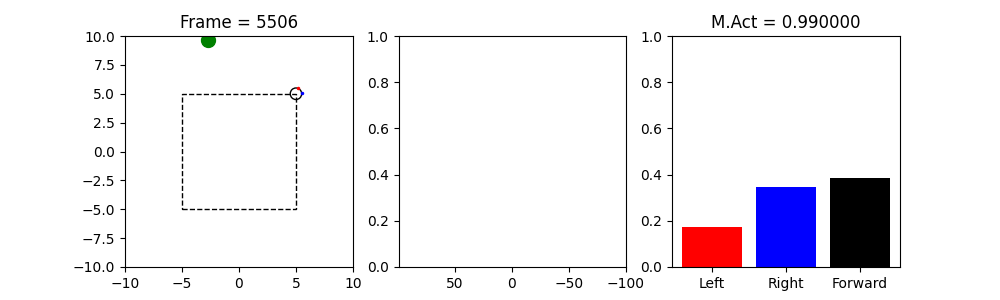

In [159]:
spikes=np.zeros(nnodes)
spike_rep=np.zeros(nnodes)
refractory=np.zeros(nnodes)
refractory_acts=np.zeros(nnodes)
targets=np.repeat(targ_min,nnodes)
acts=np.zeros(nnodes)
inputs = np.zeros(len(sens_degrees))
output_acts = np.zeros(3)

MeanErs=[]
MeanActs =[]
MeanSpikes=[]
spikes_overTime=pd.DataFrame()
spikes_overTime=spikes_overTime.append([spikes],ignore_index=True)

i=1
degree = 0
heading = 90
direction = 1
position = [0,0]
positionData=pd.DataFrame()
positionData=positionData.append([degree, heading, position],ignore_index=True)

learn_on=1
def drawframe(n):
    global circle1,position,spikes_overTime, positionData,layout,refractory,refractory_acts,noise_sd,link_decay,spike_rep,direction,degree, heading, acts, input_acts, output_acts, leak, spikes, prev_spikes, wmat, input_wmat, output_wmat, targets, errors,MeanAbsErs,MeanActs,MeanSpikes
    
    if (n %  720 == 0) and (n !=0):
        if direction == 1:
            direction = 2
        else:
            direction = 1
    
    input = get_input_acts(heading, position, degree)
        
    acts, spikes, errors, refractory,refractory_acts, prev_spikes, spike_rep = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets,refractory,refractory_acts,spike_rep)
    spikes_overTime=spikes_overTime.append([spikes],ignore_index=True)
    
    output_acts = np.dot(spikes, output_wmat)/np.sum(output_wmat, axis=0)
        
    wmat, targets = learning(learn_on,link_mat,spikes,prev_spikes, errors, wmat,targets)
    
    x, y, sLx, sLy, sRx, sRy = get_plot_vals(degree, heading, position)
    
    degree = move_stim(degree, direction)
    heading, position = move_agent(output_acts, heading, position)
    positionData=positionData.append([degree, heading, position],ignore_index=True)
    
    circle1.remove()
    circle1 = plt.Circle((position[0], position[1]), 0.5, color='black', fill = 0)
    
    ax1.add_patch(circle1)
    
    pt1.set_data(x,y)
    sL.set_data(sLx,sLy)
    sR.set_data(sRx,sRy)

    ax2.clear()
    ax2.set_ylim((0, 1))
    ax2.bar(sens_degrees,input, color = bar_colors, width=3,alpha=.4)
    ax2.invert_xaxis()
    
    bar1_plt3.set_height(output_acts[0])
    bar2_plt3.set_height(output_acts[1])
    bar3_plt3.set_height(output_acts[2])

    txt_title1.set_text('Frame = {0:4d}'.format(n))
    txt_title2.set_text('M.Err = {0:f}'.format(np.round(np.mean(errors), decimals=2)))
    txt_title3.set_text('M.Act = {0:f}'.format(np.round(np.mean(acts), decimals=2)))
    
    if (n % 100 !=0):
        MeanEr = np.mean(errors)
        MeanAbsErs.append(MeanEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        MeanSpike = np.mean(spikes)
        MeanSpikes.append(MeanSpike)
    else:
        MeanEr = np.mean(errors)
        MeanErs.append(MeanEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        MeanSpike = np.mean(spikes)
        MeanSpikes.append(MeanSpike)
        
        MeanErs_ = np.round(np.mean(MeanErs),decimals=2)
        MeanActs_ = np.round(np.mean(MeanActs),decimals=2)
        MeanSpikes_ = np.round(np.mean(MeanSpikes),decimals=2)
        print('iteration: ', str(n), ' ; MeanErs: ',str(MeanErs_), ' ; MeanAct: ', str(MeanActs_), '; MeanSpikes: ', str(MeanSpikes_))
        MeanAbsErs=[]
        MeanActs=[]
        MeanSpikes=[]
    
    return (pt1,sL,sR)

# create a figure and axes
#fig = plt.figure(figsize=(12,8))
fig = plt.figure(figsize=(10,3))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

ax1.set_xlim(( -10, 10))            
ax1.set_ylim((-10, 10))
circle1 = plt.Circle((0, 0), 0.5, color='black', fill = 0)
ax1.add_patch(Rectangle((-5, -5), 10, 10,
                       edgecolor = 'black',
                        facecolor = 'blue',
                        fill=False, linestyle = 'dashed',
                        lw=1))
ax1.add_patch(circle1)
pt1, = ax1.plot([], [], 'g.', ms=20)
sL, = ax1.plot([],[], 'r.', ms =3)
sR, = ax1.plot([],[], 'b.', ms =3)

# bar1_plt2, bar2_plt2 = ax2.bar(['sensor L', 'sensor R'],[0,0], color = ['r','b'])
ax2.set_ylim((0, 1))
bar_colors=np.array(np.repeat(['r','b'],31))
plt2 = ax2.bar(sens_degrees,inputs, color = bar_colors, width=3,alpha=.4)
ax2.invert_xaxis()

bar1_plt3, bar2_plt3, bar3_plt3 = ax3.bar(['Left', 'Right', 'Forward'],[0,0,0], color = ['r','b','black'])
ax3.set_ylim((0, 1))

txt_title1 = ax1.set_title('')
txt_title2 = ax2.set_title('')
txt_title3 = ax3.set_title('')

In [160]:
anim = animation.FuncAnimation(fig, drawframe, frames=plotIter, interval=20, blit=True)
#plt.show()
anim.save('MV_BraitenbergReservoir4_X.mp4') #v1
spikes_overTime.to_csv('spikes_overTime_Braitenberg4.csv')
positionData.to_csv('positionData_Braitenberg4.csv')

iteration:  0  ; MeanErs:  -0.83  ; MeanAct:  0.17 ; MeanSpikes:  0.0
iteration:  0  ; MeanErs:  -0.77  ; MeanAct:  0.29 ; MeanSpikes:  0.01


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in true_divide


iteration:  100  ; MeanErs:  -0.47  ; MeanAct:  1.13 ; MeanSpikes:  0.38
iteration:  200  ; MeanErs:  -0.6  ; MeanAct:  0.82 ; MeanSpikes:  0.31
iteration:  300  ; MeanErs:  -0.68  ; MeanAct:  0.0 ; MeanSpikes:  0.0
iteration:  400  ; MeanErs:  -0.6  ; MeanAct:  0.1 ; MeanSpikes:  0.04
iteration:  500  ; MeanErs:  -0.65  ; MeanAct:  0.9 ; MeanSpikes:  0.33
iteration:  600  ; MeanErs:  -0.69  ; MeanAct:  0.0 ; MeanSpikes:  0.0
iteration:  700  ; MeanErs:  -0.73  ; MeanAct:  0.04 ; MeanSpikes:  0.0
iteration:  800  ; MeanErs:  -0.76  ; MeanAct:  0.0 ; MeanSpikes:  0.0
iteration:  900  ; MeanErs:  -0.78  ; MeanAct:  0.0 ; MeanSpikes:  0.0
iteration:  1000  ; MeanErs:  -0.73  ; MeanAct:  0.18 ; MeanSpikes:  0.05
iteration:  1100  ; MeanErs:  -0.75  ; MeanAct:  0.76 ; MeanSpikes:  0.27
iteration:  1200  ; MeanErs:  -0.77  ; MeanAct:  0.0 ; MeanSpikes:  0.0
iteration:  1300  ; MeanErs:  -0.78  ; MeanAct:  0.0 ; MeanSpikes:  0.0
iteration:  1400  ; MeanErs:  -0.73  ; MeanAct:  0.77 ; MeanSpik

In [125]:
### alternate way to plot
#HTML(anim.to_html5_video())

UnboundLocalError: local variable 'w_mat' referenced before assignment